# Geopandas geoprocessing of Montgomery County, MARC, and Metro shapefiles
## Coded by Michelle Schmitz on 05/02/2021, slightly updated on 06/13/2021

**Purpose**: To reproject, buffer, and work with the following shapefiles:
* Montgomery County Esri shapefile (*from Topologically Integrated Geographic Encoding and
Referencing (TIGER) Database (MTDB) Shapefiles [(TIGR)](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) files*)
* Maryland Area Regional Commuter (MARC) Train stations (*up to 1 mile outside of Montgomery County boundaries, from [Open Data DC](https://opendata.dc.gov/datasets/3af85db360e24427a2f0f40a9b0d6fd9_97/explore)*)
* Metro train stations (*up to 1 mile outside of the Montgomery County boundaries, from [Open Data DC](https://opendata.dc.gov/datasets/54018b7f06b943f2af278bbe415df1de_52/explore)*)

In [1]:
import os
import getpass #to get username to make extensible filepath
import geopandas as gpd
import fiona #reads and writes geo files
import descartes #used for gpd plotting
import numpy as np
import matplotlib.pyplot as plt #used to plot multiple shapefiles on top of each other

### Handling Root Directories + Paths

In [2]:
# read in the file path - just breaking it down so easier to read - this assumes mapped to current data
username = getpass.getuser()
dir_root = str('C:/Users/') + username + str('/BOOZ ALLEN HAMILTON/WiDS Incubator Cohort 4 - ADU - General/GeographicData')

#assign root directory into the string
os.chdir(dir_root)
os.getcwd() #check working directory

'C:\\Users\\611322\\BOOZ ALLEN HAMILTON\\WiDS Incubator Cohort 4 - ADU - General\\GeographicData'

In [3]:
#get each path for each shapefile type

tigr_dir = dir_root + str('/Census_TIGR')
marc_dir = dir_root + str('/MARC_Rail_Stations')
metro_dir = dir_root + str('/Metro_Rail_Stations')

#state plane projection
MD_state_plane_proj = "EPSG:2248"

### Montgomery County Processing

In [4]:
Montgomery_SHP = gpd.GeoDataFrame.from_file(tigr_dir)
Montgomery_SHP

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,24,031,01712500,24031,Montgomery,Montgomery County,06,H1,G4020,548,47900,23224,A,1277148686,35731155,+39.1373815,-077.2030633,"POLYGON ((-77.43151 39.23217, -77.42615 39.234..."


<AxesSubplot:title={'center':'Montgomery County, WGS84 (lat/long)'}>

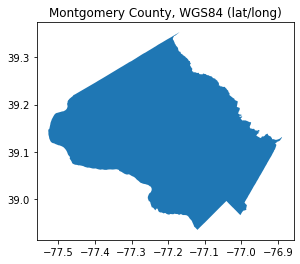

In [5]:
Mont_SHP_plt = Montgomery_SHP.plot()
Mont_SHP_plt.set_title("Montgomery County, WGS84 (lat/long)")
Mont_SHP_plt
#this plot is in WGD1984 - needs to be replotted so we can buffer in miles

In [6]:
Montgomery_SHP.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
#need to reproject to the MD 
Montgomery_SHP_MD = Montgomery_SHP.to_crs(MD_state_plane_proj)
Montgomery_SHP_MD.crs #note that units are feet!!

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:title={'center':'Montgomery County, MD State Plane'}>

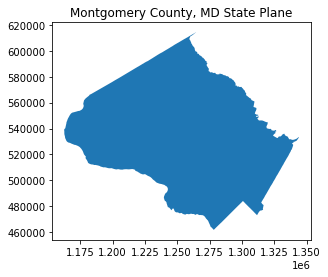

In [8]:
Mont_SHP_MD_plt = Montgomery_SHP_MD.plot()
Mont_SHP_MD_plt.set_title("Montgomery County, MD State Plane")
Mont_SHP_MD_plt

Text(0.5, 1.0, '1 mile buffer')

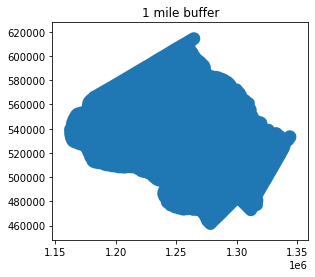

In [9]:
#now reprojected, need to create a 1-mile buffer around the outside of Montgomery County
Montgomery_SHP_MD_1miBuff = Montgomery_SHP_MD.buffer(5280) #5,280 feet in a mile
MontMD_BuffPlot = Montgomery_SHP_MD_1miBuff.plot()
MontMD_BuffPlot.set_title("1 mile buffer")

In [10]:
## writing all of the Montgomery County operations into individual GeoJSONs/SHPs (so others can use it)
# commented out because already performed - don't need to re-write.

# # Montgomery, reprojected
# Montgomery_SHP_MD.to_file("Montgomery_SHP_MD.shp")
# Montgomery_SHP_MD.to_file("Montgomery_SHP_MD.geojson", driver='GeoJSON')

# # Montgomery, reprojected, buffer
# Montgomery_SHP_MD_1miBuff.to_file("Montgomery_SHP_MD_1miBuff.shp")
# Montgomery_SHP_MD_1miBuff.to_file("Montgomery_SHP_MD_1miBuff.geojson", driver='GeoJSON')

### MARC Transformations

In [11]:
#Looking at Montgomery County-subset data
MARC_SHP = gpd.GeoDataFrame.from_file(marc_dir)
MARC_SHP #this appears to be in WGS84 as well - note the lat/long usage - note 22 stops added

,OBJECTID,Stop_or_St,Mode,geometry
0,5537,DICKERSON MARC eb,MARC,POINT (1192198.022 566024.548)
1,5538,BARNESVILLE MARC eb,MARC,POINT (1204010.351 562098.815)
2,5539,BOYDS MARC eb,MARC,POINT (1223611.459 552694.533)
3,5540,GERMANTOWN MARC eb,MARC,POINT (1235934.885 548560.627)
4,5541,METROPOLITAN GROVE MARC eb,MARC,POINT (1247937.971 540255.056)
5,5542,GAITHERSBURG MARC eb,MARC,POINT (1257495.395 537152.836)
6,5543,WASHINGTON GROVE MARC eb,MARC,POINT (1262268.619 534816.171)
7,5544,ROCKVILLE MARC eb,MARC,POINT (1270581.321 516630.339)
8,5545,GARRETT PARK MARC eb,MARC,POINT (1285816.917 499733.077)
9,5546,KENSINGTON MARC eb,MARC,POINT (1291811.287 495454.013)


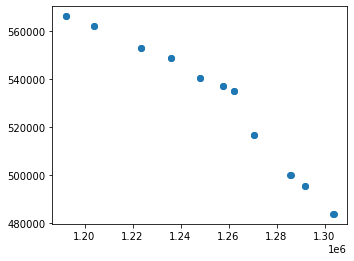

In [12]:
#plotting MARC file
MARC_plot = MARC_SHP.plot() #again, this is lat/long - not super useful

In [13]:
#need to reproject these to the MD standard
MARC_SHP_MD = MARC_SHP.to_crs(MD_state_plane_proj)
MARC_SHP_MD.crs

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
#Maryland_Area_Regional_Commuter_Train_Stops has ALL files
MARC_All_path = marc_dir + str('/Maryland_Area_Regional_Commuter_Train_Stops')
MARC_All_path

MARC_All_SHP = gpd.GeoDataFrame.from_file(MARC_All_path)
MARC_All_SHP

,OBJECTID,Stop_or_St,Mode,geometry
0,5530,MARTINSBURG W VA MARC,MARC,POINT (-77.96166 39.46112)
1,5531,DUFFIELDS W VA MARC eb,MARC,POINT (-77.82664 39.36227)
2,5532,HARPERS FERRY W VA MARC eb,MARC,POINT (-77.73057 39.32450)
3,5533,BRUNSWICK MD MARC eb,MARC,POINT (-77.62705 39.31187)
4,5534,FREDERICK MARC eb,MARC,POINT (-77.40557 39.41275)
...,...,...,...,...
74,5609,LAUREL MARC nb,MARC,POINT (-76.84211 39.10182)
75,5610,SAVAGE MARC nb,MARC,POINT (-76.79635 39.12286)
76,5611,JESSUP MARC nb,MARC,POINT (-76.77633 39.15153)
77,5612,DORSEY MARC nb,MARC,POINT (-76.74512 39.18128)


In [15]:
MARC_All_SHP.crs #note that units are lat/long and need to be reprojected!!

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'MARC Stops, All Locations, WGS 84')

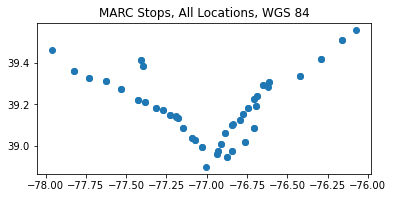

In [16]:
MARC_ALL_plot = MARC_All_SHP.plot()
MARC_ALL_plot.set_title("MARC Stops, All Locations, WGS 84") #see lots more stops - these need to be reprojected and then subset

In [17]:
MARC_All_MD_SHP = MARC_All_SHP.to_crs(MD_state_plane_proj)
MARC_All_MD_SHP.crs #note that units are feet!!

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'MARC Stops, All Locations, MD State Plane')

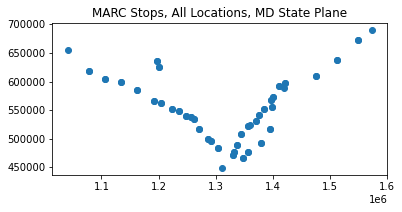

In [18]:
MARC_ALL_MD_plot = MARC_All_MD_SHP.plot()
MARC_ALL_MD_plot.set_title("MARC Stops, All Locations, MD State Plane") #see lots more stops - these need to be reprojected and then subset

In [19]:
#Time to clip the MARC stops down to the BUFFERED Montgomery County boundaries now that all boundaries are in same EPSG
MARC_Mont_Clip = gpd.clip(MARC_All_MD_SHP, Montgomery_SHP_MD_1miBuff)
MARC_Mont_Clip #note that including these in actually included a handful of facilities just outside of Montgomery County boundaries

,OBJECTID,Stop_or_St,Mode,geometry
7,5537,DICKERSON MARC eb,MARC,POINT (1192198.022 566024.548)
8,5538,BARNESVILLE MARC eb,MARC,POINT (1204010.351 562098.815)
9,5539,BOYDS MARC eb,MARC,POINT (1223611.459 552694.533)
10,5540,GERMANTOWN MARC eb,MARC,POINT (1235934.885 548560.627)
11,5541,METROPOLITAN GROVE MARC eb,MARC,POINT (1247937.971 540255.056)
12,5542,GAITHERSBURG MARC eb,MARC,POINT (1257495.395 537152.836)
13,5543,WASHINGTON GROVE MARC eb,MARC,POINT (1262268.619 534816.171)
14,5544,ROCKVILLE MARC eb,MARC,POINT (1270581.321 516630.339)
15,5545,GARRETT PARK MARC eb,MARC,POINT (1285816.917 499733.077)
16,5546,KENSINGTON MARC eb,MARC,POINT (1291811.287 495454.013)


Text(0.5, 1.0, 'MARC Stops, Within 1 mile of Montgomery County')

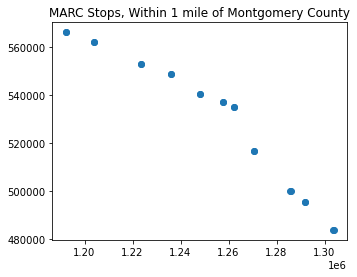

In [20]:
MARC_Mont_Clip_plot = MARC_Mont_Clip.plot()
MARC_Mont_Clip_plot.set_title("MARC Stops, Within 1 mile of Montgomery County") 

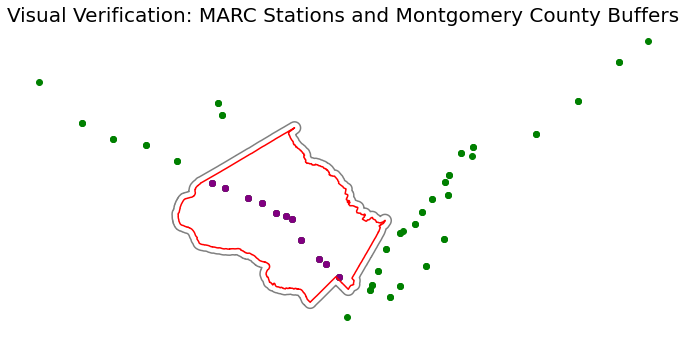

In [21]:
#Showing comparison by adding multiple shapefiles - old vs. new, along with MD county boundaries

fig, ax = plt.subplots(figsize=(12, 8))
Montgomery_SHP_MD_1miBuff.boundary.plot(ax=ax, color="gray")
Montgomery_SHP_MD.boundary.plot(ax=ax, color="red")
#MARC_Mont_Clip.plot(ax=ax,color="green")
MARC_All_MD_SHP.plot(ax=ax,color="green") #just checking the plotting here - 
# if anything was between two boundaries, we messed up
MARC_Mont_Clip.plot(ax=ax, color="purple")
ax.set_title("Visual Verification: MARC Stations and Montgomery County Buffers", fontsize=20)
ax.set_axis_off()
plt.show()

In [22]:
# MARC stations clipped to Montgomery, reprojected
# MARC_Mont_Clip.to_file("MARC_Mont_Clip.shp")
# MARC_Mont_Clip.to_file("MARC_Mont_Clip.geojson", driver='GeoJSON')

## Metro Station File Processing

In [23]:
Metro_SHP = gpd.GeoDataFrame.from_file(metro_dir)
Metro_SHP

,OBJECTID,GIS_ID,NAME,WEB_URL,ADDRESS,LINE,TRAININFO_,geometry
0,40,mstn_5,Takoma,https://www.wmata.com/rider-guide/stations/tak...,"327 CEDAR STREET NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1307164.443 476874.648)
1,41,mstn_6,Glenmont,https://www.wmata.com/rider-guide/stations/gle...,"12501 GEORGIA AVENUE, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1297124.470 508093.075)
2,42,mstn_7,Wheaton,https://www.wmata.com/rider-guide/stations/whe...,"11171 GEORGIA AVENUE, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1298099.318 499258.016)
3,43,mstn_8,Forest Glen,https://www.wmata.com/rider-guide/stations/for...,"9730 GEORGIA AVENUE, FOREST GLEN, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1300137.862 491035.755)
4,44,mstn_9,Silver Spring,https://www.wmata.com/rider-guide/stations/sil...,"8400 COLESVILLE ROAD, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1303516.082 483384.271)
5,46,mstn_11,Fort Totten,https://www.wmata.com/rider-guide/stations/for...,"550 GALLOWAY STREET NE, WASHINGTON, DC","red, green,yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1311705.325 468048.863)
6,67,mstn_32,Tenleytown-AU,https://www.wmata.com/rider-guide/stations/ten...,"4501 WISCONSIN AVENUE NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1289697.450 466967.823)
7,71,mstn_36,Friendship Heights,https://www.wmata.com/rider-guide/stations/fri...,"5337 WISCONSIN AVENUE NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1288162.905 470841.564)
8,72,mstn_37,Shady Grove,https://www.wmata.com/rider-guide/stations/sha...,"15903 SOMERVILLE DRIVE, DERWOOD, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1265624.723 529307.418)
9,73,mstn_38,Rockville,https://www.wmata.com/rider-guide/stations/roc...,"251 HUNGERFORD DRIVE, ROCKVILLE, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1270853.245 516330.375)


<AxesSubplot:>

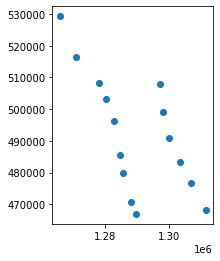

In [24]:
Metro_plot = Metro_SHP.plot() #agin, lat/long - so WGS84, and needs to be reprojected
Metro_plot

In [25]:
Metro_SHP.crs

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [26]:
#reproject, check and plot
Metro_SHP_MD = Metro_SHP.to_crs(MD_state_plane_proj)
Metro_SHP_MD.crs

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

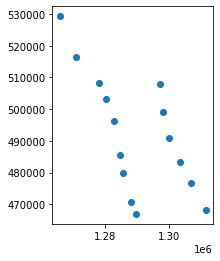

In [27]:
Metro_SHP_MD.plot()

In [28]:
#These are subset down to Montgomery proper - need to see what happens with the 1-mile buffer
Metro_All_path = metro_dir + str('/Metro_Stations_Regional')
Metro_All_path

Metro_All_SHP = gpd.GeoDataFrame.from_file(Metro_All_path)
Metro_All_SHP

,OBJECTID,GIS_ID,NAME,WEB_URL,ADDRESS,LINE,TRAININFO_,geometry
0,1,mstn_57,Archives-Navy Mem'l,https://www.wmata.com/rider-guide/stations/arc...,"701 PENNSYLVANIA AVENUE NW, WASHINGTON, DC","green, yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.02192 38.89367)
1,2,mstn_58,Waterfront,https://www.wmata.com/rider-guide/stations/wat...,"399 M STREET SW, WASHINGTON, DC",green,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.01751 38.87647)
2,3,mstn_59,Ronald Reagan Washington National Airport,https://www.wmata.com/rider-guide/stations/nat...,"2400 S. SMITH BLVD., ARLINGTON, VA","blue, yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.04404 38.85342)
3,4,mstn_60,Van Dorn Street,https://www.wmata.com/rider-guide/stations/van...,"5690 EISENHOWER AVENUE, ALEXANDRIA, VA","blue, yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.12911 38.79932)
4,5,mstn_61,Franconia-Springfield,https://www.wmata.com/rider-guide/stations/fra...,"6880 FRONTIER DRIVE, SPRINGFIELD, VA","blue, yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.16797 38.76653)
...,...,...,...,...,...,...,...,...
86,87,mstn_52,Woodley Park-Zoo Adams Morgan,https://www.wmata.com/rider-guide/stations/woo...,"2700 24TH STREET NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.05242 38.92509)
87,88,mstn_53,L'Enfant Plaza,https://www.wmata.com/rider-guide/stations/len...,"600 MARYLAND AVENUE SW, WASHINGTON, DC","grn, yllw, orange, blue, slvr",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.02191 38.88485)
88,89,mstn_54,Smithsonian,https://www.wmata.com/rider-guide/stations/smi...,"1200 INDEPENDENCE AVENUE SW, WASHINGTON, DC","blue, orange, silver",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.02807 38.88803)
89,90,mstn_55,Pentagon City,https://www.wmata.com/rider-guide/stations/pen...,"1250 SOUTH HAYES ST., ARLINGTON, VA","blue, yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.05954 38.86189)


In [29]:
#check the CRS of the original file - should be lat/long (WGS84)
Metro_All_SHP.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Metro Stops, All Locations, WGS 84')

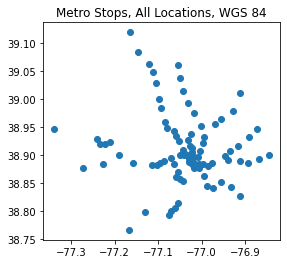

In [30]:
Metro_All_plot = Metro_All_SHP.plot()
Metro_All_plot.set_title("Metro Stops, All Locations, WGS 84") #see lots more stops - these need to be reprojected and then subset

In [31]:
#reproject these Metro stops down to state plane, then clip
Metro_All_MD_SHP = Metro_All_SHP.to_crs(MD_state_plane_proj)
Metro_All_MD_SHP.crs #note that units are feet!!

<Projected CRS: EPSG:2248>
Name: NAD83 / Maryland (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Maryland
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Metro Stops, All Locations, MD State Plane')

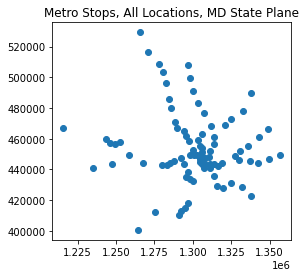

In [32]:
#plot and check
Metro_All_MD_plot = Metro_All_MD_SHP.plot()
Metro_All_MD_plot.set_title("Metro Stops, All Locations, MD State Plane")

In [33]:
Metro_Mont_Clip = gpd.clip(Metro_All_MD_SHP, Montgomery_SHP_MD_1miBuff)
Metro_Mont_Clip #note that including these in actually included a handful of facilities just outside of Montgomery County boundaries

,OBJECTID,GIS_ID,NAME,WEB_URL,ADDRESS,LINE,TRAININFO_,geometry
39,40,mstn_5,Takoma,https://www.wmata.com/rider-guide/stations/tak...,"327 CEDAR STREET NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1307164.443 476874.648)
40,41,mstn_6,Glenmont,https://www.wmata.com/rider-guide/stations/gle...,"12501 GEORGIA AVENUE, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1297124.470 508093.075)
41,42,mstn_7,Wheaton,https://www.wmata.com/rider-guide/stations/whe...,"11171 GEORGIA AVENUE, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1298099.318 499258.016)
42,43,mstn_8,Forest Glen,https://www.wmata.com/rider-guide/stations/for...,"9730 GEORGIA AVENUE, FOREST GLEN, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1300137.862 491035.755)
43,44,mstn_9,Silver Spring,https://www.wmata.com/rider-guide/stations/sil...,"8400 COLESVILLE ROAD, SILVER SPRING, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1303516.082 483384.271)
45,46,mstn_11,Fort Totten,https://www.wmata.com/rider-guide/stations/for...,"550 GALLOWAY STREET NE, WASHINGTON, DC","red, green,yellow",https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1311705.325 468048.863)
66,67,mstn_32,Tenleytown-AU,https://www.wmata.com/rider-guide/stations/ten...,"4501 WISCONSIN AVENUE NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1289697.450 466967.823)
70,71,mstn_36,Friendship Heights,https://www.wmata.com/rider-guide/stations/fri...,"5337 WISCONSIN AVENUE NW, WASHINGTON, DC",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1288162.905 470841.564)
71,72,mstn_37,Shady Grove,https://www.wmata.com/rider-guide/stations/sha...,"15903 SOMERVILLE DRIVE, DERWOOD, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1265624.723 529307.418)
72,73,mstn_38,Rockville,https://www.wmata.com/rider-guide/stations/roc...,"251 HUNGERFORD DRIVE, ROCKVILLE, MD",red,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (1270853.245 516330.375)


Text(0.5, 1.0, 'Metro Stops, Within 1 mile of Montgomery County')

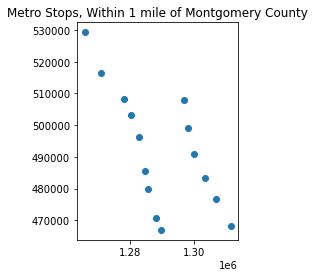

In [34]:
Metro_Mont_Clip_plot = Metro_Mont_Clip.plot()
Metro_Mont_Clip_plot.set_title("Metro Stops, Within 1 mile of Montgomery County") 

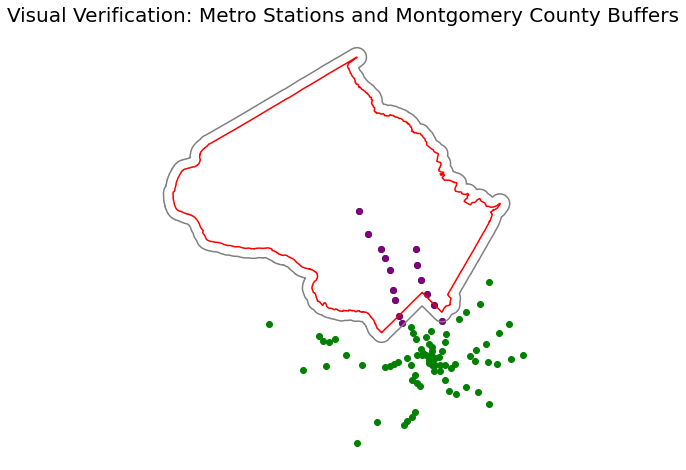

In [35]:
#Showing comparison by adding multiple shapefiles - old vs. new, along with MD county boundaries

fig, ax = plt.subplots(figsize=(12, 8))
Montgomery_SHP_MD_1miBuff.boundary.plot(ax=ax, color="gray")
Montgomery_SHP_MD.boundary.plot(ax=ax, color="red")
Metro_All_MD_SHP.plot(ax=ax,color="green") #just checking the plotting here - 
# if anything was between two boundaries, we messed up
Metro_Mont_Clip.plot(ax=ax, color="purple")
ax.set_title("Visual Verification: Metro Stations and Montgomery County Buffers", fontsize=20)
ax.set_axis_off()
plt.show()

We see that there are about 3 or 4 stops that count as being within 1 mile of the overall Montgomery county radius, and must be included in our analyses.

In [36]:
#Export the clipped Metro stations as a new SHP and KML file
# Metro stations clipped to Montgomery buffer, reprojected
# Metro_Mont_Clip.to_file("Metro_Mont_Clip.shp")
# Metro_Mont_Clip.to_file("Metro_Mont_Clip.geojson", driver='GeoJSON')

## Creating total plot comparing MARC to Metro to Montgomery County



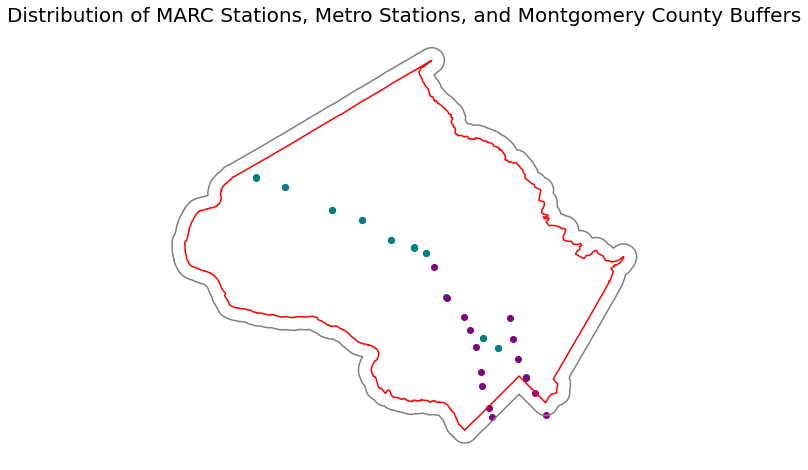

In [37]:
#Showing comparison by adding multiple shapefiles - old vs. new, along with MD county boundaries

fig, ax = plt.subplots(figsize=(12, 8))
Montgomery_SHP_MD_1miBuff.boundary.plot(ax=ax, color="gray")
Montgomery_SHP_MD.boundary.plot(ax=ax, color="red")
MARC_Mont_Clip.plot(ax=ax,color="teal")
Metro_Mont_Clip.plot(ax=ax, color="purple")
ax.set_title("Distribution of MARC Stations, Metro Stations, and Montgomery County Buffers", fontsize=20)
ax.set_axis_off()
plt.show()

<AxesSubplot:>

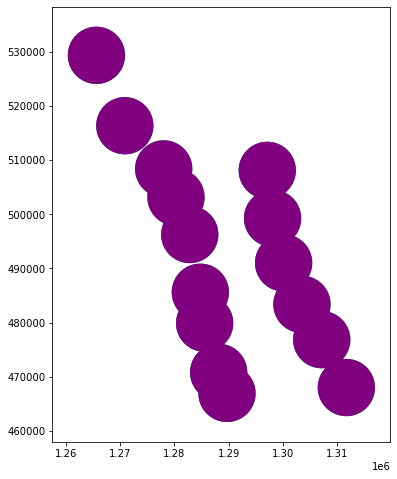

In [38]:
## Consolidation between two stations

MARC_Mont_Clip_Buffer = MARC_Mont_Clip.buffer(5280)
Metro_Mont_Clip_Buffer = Metro_Mont_Clip.buffer(5280)

## best practice is usually to first buffer each
# then union
# dissolve
fig, ax = plt.subplots(figsize=(12, 8))
#MARC_Mont_Clip.plot(ax=ax,color="darkteal")
Metro_Mont_Clip_Buffer.plot(ax=ax,color="teal")
#Metro_Mont_Clip.plot(ax=ax,color="darkpurple")
Metro_Mont_Clip_Buffer.plot(ax=ax,color="purple")

In [39]:
# MARC_Mont_Clip_Buffer.to_file("MARC_Mont_Clip_Buffer.shp")
# MARC_Mont_Clip_Buffer.to_file("MARC_Mont_Clip_Buffer.geojson", driver='GeoJSON')

In [40]:
# Metro_Mont_Clip_Buffer.to_file("Metro_Mont_Clip_Buffer.shp")
# Metro_Mont_Clip_Buffer.to_file("Metro_Mont_Clip_Buffer.geojson", driver='GeoJSON')

In [41]:
# # MARC_All_path
# MARC_Mont_Clip

In [46]:
## geopandas data frame for both
MARC_Mont_Clip_Buffer_gdf = gpd.GeoDataFrame.from_file('C:/Users/611322/BOOZ ALLEN HAMILTON/WiDS Incubator Cohort 4 - ADU - General/GeographicData/MARC_Mont_Clip_Buffer.geojson')
MARC_Mont_Clip_Buffer_gdf #need to join data based on geometry

,geometry
0,"POLYGON ((1197478.022 566024.548, 1197452.597 ..."
1,"POLYGON ((1209290.351 562098.815, 1209264.926 ..."
2,"POLYGON ((1228891.459 552694.533, 1228866.034 ..."
3,"POLYGON ((1241214.885 548560.627, 1241189.461 ..."
4,"POLYGON ((1253217.971 540255.056, 1253192.546 ..."
5,"POLYGON ((1262775.395 537152.836, 1262749.970 ..."
6,"POLYGON ((1267548.619 534816.171, 1267523.194 ..."
7,"POLYGON ((1275861.321 516630.339, 1275835.897 ..."
8,"POLYGON ((1291096.917 499733.077, 1291071.492 ..."
9,"POLYGON ((1297091.287 495454.013, 1297065.862 ..."


In [47]:
## geopandas data frame for both
Metro_Mont_Clip_Buffer_gdf = gpd.GeoDataFrame.from_file('C:/Users/611322/BOOZ ALLEN HAMILTON/WiDS Incubator Cohort 4 - ADU - General/GeographicData/Metro_Mont_Clip_Buffer.geojson')
Metro_Mont_Clip_Buffer_gdf #need to join data based on geometry

,geometry
0,"POLYGON ((1312444.443 476874.648, 1312419.018 ..."
1,"POLYGON ((1302404.470 508093.075, 1302379.046 ..."
2,"POLYGON ((1303379.318 499258.016, 1303353.894 ..."
3,"POLYGON ((1305417.862 491035.755, 1305392.437 ..."
4,"POLYGON ((1308796.082 483384.271, 1308770.658 ..."
5,"POLYGON ((1316985.325 468048.863, 1316959.900 ..."
6,"POLYGON ((1294977.450 466967.823, 1294952.026 ..."
7,"POLYGON ((1293442.905 470841.564, 1293417.481 ..."
8,"POLYGON ((1270904.723 529307.418, 1270879.299 ..."
9,"POLYGON ((1276133.245 516330.375, 1276107.820 ..."


In [48]:
# #join attribute data to this
# MARC_Mont_Clip_Buffer_gdf.join(MARC_Mont_Clip,on='geometry')

<AxesSubplot:>

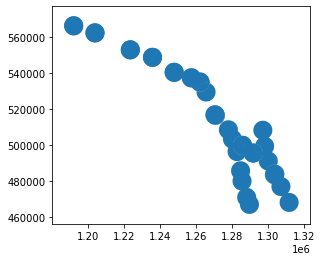

In [49]:
res_union = gpd.overlay(MARC_Mont_Clip_Buffer_gdf, Metro_Mont_Clip_Buffer_gdf, how='union')
res_union.plot()

In [ ]:
# res_union_dissolve = res_union.dissolve(by=all)